In [4]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt
from scipy.stats import norm

# Monte Carlo for pricing Europen options 

## European binary option:  
$$ f(S(N)) = \theta(S(N) - X)$$

## European call option:  
$$ f(S(N)) = max(S(N) - X, 0)$$

## European put option: 
$$ f(S(N)) = max(X - S(N), 0)$$

In [93]:
binary_payoff = lambda S, X: np.heaviside(S - X, 0) 
call_payoff = lambda S, X: np.maximum(S - X, 0)
put_payoff = lambda S, X: np.maximum(X - S, 0)

Brownian motion stock dynamics


S=1, X=1, T=1, σ =0.2, r=0.1 

$$S(t) = S\exp\left( \left(r - \frac{\sigma^2}{2} \right)t + \sigma W_t\right) $$

In [82]:
S = X = T = 1
r = 0.1
sigma = 0.2

# function generates N stocks trajectories (only end points) 
def generate_trajec_end(N, S0, sigma,r , T):
    return S0 * np.exp((r - sigma * sigma / 2) * T + sigma * np.sqrt(T) * norm.rvs(size=N, scale=1))
    
def option_monte_carlo(payoff_func, N, S0, X, sigma, r, T):
    s = generate_trajec_end(N, S0, sigma,r, T)
    payoffs = payoff_func(s, X) * np.exp(-r * T)
    mean, std = np.mean(payoffs), np.std(payoffs) / np.sqrt(N - 1)
    
    return mean, std


In [96]:
print("Call From Monte Carlo (100k trajectories): ", option_monte_carlo(call_payoff, 100000, S, X, sigma, r, T))
print("Put From Monte Carlo (100k trajectories): ", option_monte_carlo(put_payoff, 100000, S, X, sigma, r, T))
print("Binary From Monte Carlo (100k trajectories): ", option_monte_carlo(binary_payoff, 100000, S, X, sigma, r, T))

Call From Monte Carlo (100k trajectories):  (np.float64(0.5687943941043219), np.float64(0.003983416270230643))
Put From Monte Carlo (100k trajectories):  (np.float64(0.1165339821897054), np.float64(0.0004951557418605555))
Binary From Monte Carlo (100k trajectories):  (np.float64(0.29667659423970877), np.float64(0.000864889088490315))


# Monte Carlo methods for contracts with early exercise 


At each time step $t_m$, the option holder must decide between:

1. **Exercising the option** → Receive the immediate payoff:
   $$
   P_{t_m} = \max(S_{t_m} - K, 0)
   $$

2. **Continuing to hold the option** → Receive the expected discounted future value:
   $$
   C_{t_m} = \mathbb{E}_m \left[ e^{-r \Delta t} V_{t_{m+1}} \mid S_{t_m} \right]
   $$

where:
- $C_{t_m}$ is the **continuation value**, i.e., the expected value of holding the option,
- $\mathbb{E}_m [ \cdot \mid S_{t_m} ]$ is the expectation given the current stock price $S_{t_m}$,
- $V_{t_{m+1}}$ is the **value function** at the next step,
- $e^{-r \Delta t}$ is the discount factor for one time step.

---

Since we don't have a closed-form solution for $C_{t_m}$, we **approximate it using regression** on simulated paths.

At each time step $t_m$, we focus only on paths where early exercise is possible, i.e., those where:
$$
S_{t_m} > K
$$
For these paths, we compute the discounted **future cashflows** as:
$$
Y_i = e^{-r \Delta t} V_{t_{m+1}}^i
$$
where $V_{t_{m+1}}^i$ is the **option value** in the next time step along path $i$.

Since $C_t = \mathbb{E}_m [ e^{-r \Delta t} V_{t_{m+1}} \mid S_t ]$, we approximate $C_t$ using a **polynomial basis function**:
$$
C_t \approx \sum_{j=0}^{d} a_j \phi_j(S_t)
$$
where:
- $\phi_j(S_t)$ are basis functions (typically **polynomials** in $S_t$),
- $a_j$ are regression coefficients to be determined,
- $d$ is the polynomial degree (typically **low**, e.g., 2 or 3).

For the paths in the money, we solve for $a_j$ by minimizing the **mean squared error**:
$$
\min_{a_0, a_1, ..., a_d} \sum_{i} \left( Y_i - \sum_{j=0}^{d} a_j \phi_j(S_{t_m}^i) \right)^2
$$

This is a standard **linear regression** problem:
$$
A \mathbf{a} = \mathbf{Y}
$$
where:
- $A$ is a matrix whose $i$-th row is $[1, S_{t_m}^i, (S_{t_m}^i)^2, ..., (S_{t_m}^i)^d]$,
- $\mathbf{a} = [a_0, a_1, ..., a_d]^T$ is the coefficient vector,
- $\mathbf{Y}$ is the vector of discounted future payoffs.

The solution is obtained using **least squares regression**:
$$
\mathbf{a} = (A^T A)^{-1} A^T \mathbf{Y}
$$

Using the fitted regression model, we estimate the continuation value for each stock price:
$$
C_{t_m}^i = \sum_{j=0}^{d} a_j \phi_j(S_{t_m}^i)
$$

---

For each path $i$, we compare the immediate exercise value $P_{t_m}^i$ to the estimated continuation value $C_{t_m}^i$:

- **If** $P_{t_m}^i > C_{t_m}^i$ → **Exercise the option**  
  - Set the option value:  
    $$
    V_{t_m}^i = P_{t_m}^i
    $$
  - Discard all future payoffs (since the option is exercised).

- **If** $P_{t_m}^i \leq C_{t_m}^i$ → **Hold the option**  
  - Discount the next step value:  
    $$
    V_{t_m}^i = e^{-r \Delta t} V_{t_{m+1}}^i
    $$

This process is repeated **backward** from $T$ to $t_0$.

---

Once we have determined the optimal exercise decisions along all paths, the price of the American option is simply the **average discounted payoff**:
$$
V_0 = \frac{1}{N} \sum_{i=1}^{N} e^{-r t_{\text{exercise}}^i} P_{\text{exercise}}^i
$$

where:
- $P_{\text{exercise}}^i$ is the payoff at the optimal exercise time for path $i$,
- $t_{\text{exercise}}^i$ is the corresponding exercise time.

---

At each time step $t_m$, we:
1. Identify paths **in the money** ($S_{t_m} > K$).
2. Compute **discounted future payoffs**.
3. Perform **least-squares regression** to estimate the **continuation value $C_{t_m}$**.
4. Compare $C_{t_m}$ with the **immediate exercise value $P_{t_m}$**.
5. Decide whether to **exercise or hold**.
6. Move **backward in time** until $t_0$.

This ensures that the Monte Carlo simulation captures the **optimal exercise strategy** for the American option.


In [ ]:
def generate_trajec_full(N, S0, sigma,r, t):
    dt = t[1] - t[0]
    dW = norm.rvs(size=(len(t) , N)) * np.sqrt(dt)
    W = np.cumsum(dW, axis=0)

    S = S0 * np.exp((r - 0.5 * sigma**2) * t[:, np.newaxis] + sigma * W)

    return S

Text(0.5, 0, 't')

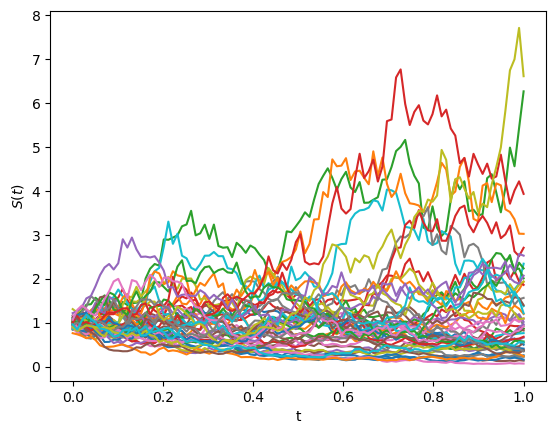

In [92]:
time = np.linspace(0, 1, 100)

sigma = 1.0
r = 0.6
S0 = 1

for traj in np.transpose(generate_trajec_full(50, S0, sigma,r, time)):
    plt.plot(time, traj)

plt.ylabel(r"$S(t)$")
plt.xlabel("t")

In [ ]:
call_exercise = lambda S, K: S - K

In [188]:
def option_least_squares_mc(exercise_func, N, S0, K, sigma, r, M, T):
    time = np.linspace(0, T, M)
    dt = time[1] - time[0]

    S = generate_trajec_full(N, S0, sigma, r, time)

    payoffs = np.maximum(exercise_func(S[-1, :], K), 0)
    t_exercies = np.ones(N) * T

    for t in range(M-1, 0, -1):
        in_money = exercise_func(S[t, :], K) > 0

        if np.sum(in_money) == 0:
            continue

        X = S[t, in_money]
        Y = np.exp(-r * dt) * payoffs[in_money]
        
        X = S[t, :]
        Y = np.exp(-r * dt) * payoffs[:]

        A = np.vstack([np.ones_like(X), X, X**2]).T 
        coeffs = np.linalg.lstsq(A, Y, rcond=None)[0]

        C = np.dot(A, coeffs)

        P = np.maximum(exercise_func(X, K), 0)

        exercise_condition = P > C

        payoffs[exercise_condition] = P[exercise_condition]
        t_exercies[exercise_condition] = t * dt

        # print(payoffs[49])

    return np.sum(np.exp(- r * t_exercies) * payoffs) / N

In [207]:
S0 = K = T = 1
r = 0.1
sigma = 0.7
M = 1000
N = 1000

option_least_squares_mc(call_exercise, N, S0, X, sigma, r, M, T)

np.float64(0.2916233170381893)

## **1. Binomial Model for American Call Options**
The **binomial model** is a discrete-time numerical method for pricing options. It models the underlying asset price as a **binomial tree**, where at each time step, the price can either **increase** or **decrease** with certain probabilities.

### **1.1. Mathematical Formulation**
We divide the time to expiration $T$ into $N$ discrete time steps $\Delta t = T/N$, and model the stock price evolution as:

$$ S_{t+\Delta t} = \begin{cases} S_t \cdot u, & \text{with probability } p \\ S_t \cdot d, & \text{with probability } (1-p) \end{cases} $$

where:
- $ u = e^{\sigma \sqrt{\Delta t}} $ (up factor),
- $ d = e^{-\sigma \sqrt{\Delta t}} $ (down factor),
- $ p = \frac{e^{r \Delta t} - d}{u - d} $ (risk-neutral probability),
- $ \sigma $ is the volatility,
- $ r $ is the risk-free rate.

At each node, the option value is determined by **backward induction**.

### **1.2. Backward Induction for American Options**
The value of the option at expiration is:

$$ V_N(i) = \max(S_N(i) - K, 0) $$

where $ K $ is the strike price.

For earlier time steps, the value is computed as:

$$ V_m(i) = \max(S_m(i) - K, e^{-r \Delta t} (p V_{m+1}(i+1) + (1-p) V_{m+1}(i))) $$

where:
- $ e^{-r \Delta t} (p V_{m+1}(i+1) + (1-p) V_{m+1}(i)) $ is the **expected continuation value** under the risk-neutral measure,
- $ S_m(i) - K $ is the **immediate exercise value**.

The **early exercise condition** ensures that if exercising the option is more valuable than holding it, we take the immediate payoff.

### **1.3. Algorithm for the Binomial Model**
1. **Initialize parameters:** Set $ S_0 $, $ K $, $ T $, $ r $, $ \sigma $, and the number of time steps $ N $.
2. **Build the stock price tree:** Compute all possible values of $ S_m(i) $ for each time step.
3. **Compute option values at maturity:** Set $ V_N(i) = \max(S_N(i) - K, 0) $.
4. **Perform backward induction:** For each node at time step $ m $, compute:
   - The continuation value using risk-neutral expectation.
   - The immediate exercise value $ S_m(i) - K $.
   - The option value as $ V_m(i) = \max(\text{exercise value}, \text{continuation value}) $.
5. **Obtain the final option price:** The value at the root node $ V_0(0) $ is the option price.



In [ ]:
def binomial_american_call(exercise_func, S0, K, sigma, r, M, T):
    dt = T / M
    
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u                      
    p = (np.exp(r * dt) - d) / (u - d) 
    discount = np.exp(-r * dt) 
    
    stock_prices = np.zeros((M+1, M+1))

    for i in range(M+1): # loop over time steps
        for j in range(i+1): # loop over tree branches 
            stock_prices[j, i] = S0 * (u ** (i - j)) * (d ** j)
    
    option_values = np.maximum(exercise_func(stock_prices[:, M] , K), 0)
    
    for i in range(M-1, -1, -1): # loop over time steps (backward)
        for j in range(i+1): # loop over tree branches 
            continuation_value = discount * (p * option_values[j] + (1 - p) * option_values[j+1])
            exercise_value = stock_prices[j, i] - K
            option_values[j] = max(continuation_value, exercise_value)
    
    return option_values[0]

In [208]:
binomial_american_call(call_exercise, S0, X, sigma, r, M, T)

np.float64(0.3107015992641313)

### **Finite Difference Method for American Call Option Pricing**  

The **Finite Difference Method (FDM)** is a numerical approach for solving partial differential equations (PDEs), including the **Black-Scholes (BS) equation**. For an **American call option**, we must account for early exercise, which makes the problem more complex than the European case.  

---

## **1. Black-Scholes Equation for an American Call Option**  
The Black-Scholes equation for an option price $ V(S,t) $ is:

$$
\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + r S \frac{\partial V}{\partial S} - r V = 0
$$

where:
- $ V(S,t) $ is the option price as a function of stock price $ S $ and time $ t $,
- $ \sigma $ is the volatility of the stock,
- $ r $ is the risk-free interest rate,
- $ S $ is the stock price,
- $ t $ is time (with $ t = 0 $ being the current time and $ t = T $ the expiration time).

For an **American call option**, we impose the **early exercise condition**:

$$
V(S, t) \geq \max(0, S - K)
$$

where $ K $ is the strike price. This means that the value of the option must always be at least as large as the intrinsic value $ (S - K) $.

---

## **2. Discretization Using Finite Difference Method**
To numerically solve the Black-Scholes PDE, we use **finite differences** by discretizing time and space.

### **2.1 Discretization Grid**
- Divide stock price into discrete points:  
  $$ S_m = m \Delta S, \quad m = 0, 1, ..., M $$
  where $ \Delta S $ is the stock price step.
  
- Divide time into discrete points:  
  $$ t_n = n \Delta t, \quad n = 0, 1, ..., N $$
  where $ \Delta t $ is the time step.

Thus, we approximate the derivatives in the Black-Scholes equation at a grid point $ (S_m, t_n) $.

### **2.2 Finite Difference Approximation**
Using **explicit, implicit, or Crank-Nicolson** schemes, we approximate the derivatives:

- **Time derivative (backward difference):**
  $$ \frac{\partial V}{\partial t} \approx \frac{V_m^{n+1} - V_m^n}{\Delta t} $$
  
- **First-order spatial derivative (central difference):**
  $$ \frac{\partial V}{\partial S} \approx \frac{V_{m+1}^n - V_{m-1}^n}{2 \Delta S} $$
  
- **Second-order spatial derivative (central difference):**
  $$ \frac{\partial^2 V}{\partial S^2} \approx \frac{V_{m+1}^n - 2V_m^n + V_{m-1}^n}{\Delta S^2} $$

Substituting these into the Black-Scholes equation:

$$
\frac{V_m^{n+1} - V_m^n}{\Delta t} + \frac{1}{2} \sigma^2 S_m^2 \frac{V_{m+1}^n - 2V_m^n + V_{m-1}^n}{\Delta S^2} + r S_m \frac{V_{m+1}^n - V_{m-1}^n}{2 \Delta S} - r V_m^n = 0
$$

Rearrange to match the numerical scheme format:

$$
V_m^{n+1} = a_m V_{m-1}^{n} + b_m V_m^n + c_m V_{m+1}^n
$$

where the coefficients are:

$$
a_m = \frac{\Delta t}{2} \left( \sigma^2 \frac{S_m^2}{\Delta S^2} - r \frac{S_m}{\Delta S} \right)
$$

$$
b_m = 1 - \Delta t \left( \sigma^2 \frac{S_m^2}{\Delta S^2} + r \right)
$$

$$
c_m = \frac{\Delta t}{2} \left( \sigma^2 \frac{S_m^2}{\Delta S^2} + r \frac{S_m}{\Delta S} \right)
$$

---

## **3. Algorithm for American Call Option Pricing**
1. **Initialize grid:**
   - Set up stock price grid $ S_m $ and time grid $ t_n $.
   - Compute step sizes $ \Delta S $ and $ \Delta t $.

2. **Set boundary conditions:**
   - At $ S = 0 $, set $ V(0,t) = 0 $.
   - At large $ S $, set $ V(S,t) = S - K $.
   - At $ t = T $ (expiry), set $ V_m^N = \max(S_m - K, 0) $.

3. **Step backward in time (from $ t_N $ to $ t_0 $):**
   - Use implicit or Crank-Nicolson method to compute $ V_m^{n} $.
   - Apply early exercise condition.

4. **Output $ V(S_0, 0) $, the option price at $ S_0 $.**

---

## **4. Which Method is Best?**
- **Explicit:** Only useful for small $ N $ due to instability.
- **Implicit:** Good for stability but less accurate.
- **Crank-Nicolson:** Best choice as it is stable and accurate.

**For American options**, implicit or Crank-Nicolson with early exercise checking is recommended.


In [ ]:
def BS_finite_diff(exercise_func, S, K,  T, sigma, r, N, M):
    ds = S / (N - 1)
    dt = T / (M - 1)
    s = np.arange(N) * ds
    t = np.arange(M) * dt

    V = np.zeros((N, M))
    V[N-1, :] = S - K
    V[:, M-1] = np.maximum(exercise_func(s, K) , 0)

    a = dt / 2 * (sigma * sigma / ds / ds * s * s - r * s / ds)
    b = 1 - dt * (sigma * sigma / ds / ds * s * s + r)
    c = dt / 2 * (sigma * sigma / ds / ds * s * s + r * s / ds)



In [228]:
S = 10
K = 1
T = 1
N = 50
M = 40

BS_finite_diff(call_exercise, S, K, T, sigma, r, N, M)